### Imputation DAE - HP prediction model

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import re

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
xgb.__version__
%matplotlib inline

/opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
hp="/gpfs/group/torkamani/loguerci/INCITE/all_summary.csv"

#vmv_features="/mnt/stsi/stsi6/Internal/INCITE/summary_VMV_features.txt"

In [3]:
hp_data = pd.read_csv(hp)

In [4]:
print(hp_data.shape)
hp_data

(1969711, 23)


,Unnamed: 0,number,value,params_L1,params_L2,params_activation,params_batch_size,params_beta,params_decay_rate,params_disable_alpha,...,params_learn_rate,params_loss_type,params_n_layers,params_optimizer_type,params_rho,params_size_ratio,state,chr,start,end
0,1,1,0.076222,1.364351e-14,5.574900e-03,relu,512.0,2.847440,1.783599e-05,1.0,...,0.000949,CE,10.0,sgd,0.565043,0.804759,PRUNED,1,100065006,100404358.0
1,2,2,0.183240,2.874493e-14,1.903664e-14,relu,512.0,4.580462,3.696021e-07,1.0,...,0.000027,FL,4.0,radam,0.972788,0.717024,COMPLETE,1,100065006,100404358.0
2,3,3,0.341808,1.620363e-05,2.608037e-02,tanh,128.0,0.063531,1.253657e-05,1.0,...,0.000045,CE,6.0,adam,0.625708,0.674909,COMPLETE,1,100065006,100404358.0
3,4,4,0.000051,1.930438e-01,1.657393e-01,sigmoid,512.0,0.349225,5.109090e-07,1.0,...,0.006191,CE,4.0,adam,0.255226,0.891275,PRUNED,1,100065006,100404358.0
4,5,5,0.290138,2.239995e-16,2.224344e-16,relu,256.0,0.821639,2.188565e-02,1.0,...,0.000010,CE,10.0,adam,0.239580,0.422854,COMPLETE,1,100065006,100404358.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969706,295,295,0.316052,1.058559e-08,7.924662e-09,sigmoid,512.0,2.497729,5.154877e-01,1.0,...,0.000358,CE,2.0,adam,0.383286,0.554727,COMPLETE,22,50933275,NaN
1969707,296,296,0.177156,9.244516e-09,6.626634e-09,relu,256.0,2.454046,3.291996e-01,1.0,...,0.000332,CE,2.0,radam,0.324878,0.502709,COMPLETE,22,50933275,NaN
1969708,297,297,0.181595,1.019317e-08,8.299636e-09,relu,256.0,2.630322,4.682305e-01,1.0,...,0.000309,CE,2.0,radam,0.455969,0.623670,COMPLETE,22,50933275,NaN
1969709,298,298,0.312961,9.218938e-09,9.159179e-09,sigmoid,512.0,2.602182,4.263841e-01,1.0,...,0.000321,CE,2.0,adam,0.297225,0.753008,COMPLETE,22,50933275,NaN


In [5]:
# drop dup column
hp_data=hp_data.drop('Unnamed: 0',axis=1)

In [6]:
# add a column for tile by pasting chr, start, stop: chr_start-stop.
hp_data["tile"]=hp_data.chr.map(str) + "_" + hp_data["start"].astype(int).map(str) +"-"+hp_data["end"].fillna("").map(str).str.replace(".0","",regex=False)

In [7]:
# rename columns
hp_data.columns=hp_data.columns.str.replace("params_","",regex=False)

In [8]:
hp_data.rename(columns = {"number":"model_id","value":"r2"}, inplace=True)

In [9]:
hp_data.rename(columns={"optimizer_type":"optimizer"}, inplace=True)

In [10]:
hp_data.columns

Index(['model_id', 'r2', 'L1', 'L2', 'activation', 'batch_size', 'beta',
       'decay_rate', 'disable_alpha', 'flip_alpha', 'gamma', 'inverse_alpha',
       'learn_rate', 'loss_type', 'n_layers', 'optimizer', 'rho', 'size_ratio',
       'state', 'chr', 'start', 'end', 'tile'],
      dtype='object')

In [11]:
hp_data.describe()

,model_id,r2,L1,L2,batch_size,beta,decay_rate,disable_alpha,flip_alpha,gamma,inverse_alpha,learn_rate,n_layers,rho,size_ratio,chr,start,end
count,1.969711e+06,1.969711e+06,1.945479e+06,1.945479e+06,1.945479e+06,1.945479e+06,1.945479e+06,1.945479e+06,869456.000000,869456.000000,869456.000000,1.945479e+06,1.945479e+06,1.945479e+06,1.945479e+06,1.969711e+06,1.969711e+06,1.968625e+06
mean,1.940496e+02,1.038841e-01,2.774898e-02,2.838358e-02,1.579225e+02,2.489452e+00,8.839141e-02,6.945189e-01,0.318170,3.668609,0.424377,2.574500e-03,6.428777e+00,4.908925e-01,6.732225e-01,9.509255e+00,8.201124e+07,8.214019e+07
std,2.703514e+02,1.221132e-01,1.194843e-01,1.206837e-01,1.402328e+02,1.376804e+00,1.985495e-01,4.606110e-01,0.465766,1.974471,0.494248,3.614374e-03,2.969309e+00,2.767503e-01,2.204654e-01,6.671185e+00,6.353112e+07,6.352462e+07
min,0.000000e+00,-1.000000e+00,1.000001e-16,1.000013e-16,6.400000e+01,6.768138e-07,1.000002e-08,0.000000e+00,0.000000,0.000005,0.000000,1.000004e-05,2.000000e+00,3.845531e-08,2.500003e-01,1.000000e+00,1.473200e+05,1.883510e+05
25%,7.900000e+01,9.391506e-03,1.433095e-12,5.010919e-12,6.400000e+01,1.430697e+00,1.088513e-06,0.000000e+00,0.000000,1.824784,0.000000,7.156647e-05,4.000000e+00,2.727209e-01,4.968344e-01,3.000000e+00,2.665818e+07,2.684859e+07
50%,1.620000e+02,5.052161e-02,9.901278e-09,1.053568e-08,1.280000e+02,2.504633e+00,1.066478e-04,1.000000e+00,0.000000,3.707371,0.000000,4.404676e-04,6.000000e+00,4.848796e-01,6.741992e-01,1.000000e+01,6.725256e+07,6.733888e+07
75%,2.470000e+02,1.812595e-01,1.977279e-05,3.247159e-05,1.280000e+02,3.498114e+00,2.109115e-02,1.000000e+00,1.000000,5.318160,1.000000,4.041630e-03,1.000000e+01,7.108978e-01,8.817813e-01,1.600000e+01,1.248436e+08,1.249801e+08
max,1.785700e+04,5.666788e-01,9.999951e-01,9.999973e-01,5.120000e+02,4.999998e+00,9.999754e-01,1.000000e+00,1.000000,6.999999,1.000000,1.000000e-02,1.200000e+01,9.999999e-01,9.999999e-01,2.200000e+01,2.480467e+08,2.483429e+08


(-0.1, 1.0)

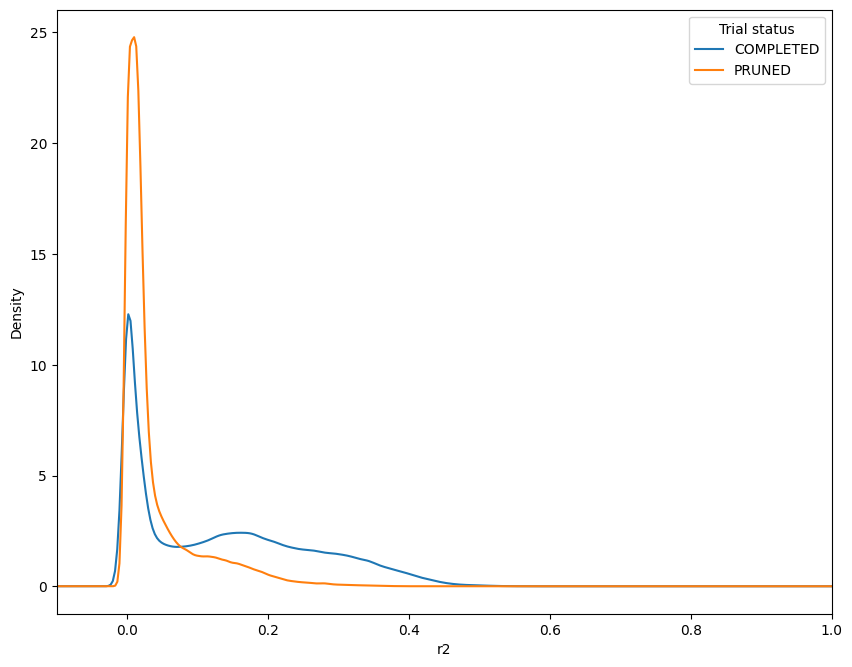

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=100)

hp_data.groupby('state')['r2'].plot(kind='kde')
print()

# Add legend to plot
plt.legend(['COMPLETED', 'PRUNED'], title='Trial status')

# Add x-axis label
plt.xlabel('r2') 
plt.xlim([-0.1,1.0])


In [ ]:
plt.savefig('r2_compl_pruned.png',dpi=100)

### Descriptive statistics (r^2) for completed and pruned trials 

- Summaries:

In [12]:
hp_data[hp_data["state"]=="COMPLETE"]["r2"].describe()

count    1.406851e+06
mean     1.308125e-01
std      1.281104e-01
min     -1.000000e+00
25%      1.287053e-02
50%      1.105811e-01
75%      2.224285e-01
max      5.666788e-01
Name: r2, dtype: float64

In [13]:
hp_data[hp_data["state"]=="PRUNED"]["r2"].describe()

count    562860.000000
mean          0.036577
std           0.069413
min          -1.000000
25%           0.006344
50%           0.015537
75%           0.042531
max           0.486525
Name: r2, dtype: float64



- NaN content:

In [14]:
hp_data[hp_data["state"]=="COMPLETE"].isna().sum()

model_id              0
r2                    0
L1                24232
L2                24232
activation        24232
batch_size        24232
beta              24232
decay_rate        24232
disable_alpha     24232
flip_alpha       829288
gamma            829288
inverse_alpha    829288
learn_rate        24232
loss_type         24232
n_layers          24232
optimizer         24232
rho               24232
size_ratio        24232
state                 0
chr                   0
start                 0
end                 816
tile                  0
dtype: int64

In [15]:
hp_data[hp_data["state"]=="PRUNED"].isna().sum()

model_id              0
r2                    0
L1                    0
L2                    0
activation            0
batch_size            0
beta                  0
decay_rate            0
disable_alpha         0
flip_alpha       270967
gamma            270967
inverse_alpha    270967
learn_rate            0
loss_type             0
n_layers              0
optimizer             0
rho                   0
size_ratio            0
state                 0
chr                   0
start                 0
end                 270
tile                  0
dtype: int64

In [16]:
hp_data[hp_data["r2"]<0]["r2"].describe()

count    2093.0
mean       -1.0
std         0.0
min        -1.0
25%        -1.0
50%        -1.0
75%        -1.0
max        -1.0
Name: r2, dtype: float64

## Filter hp_data

- ### Columns

In [12]:
hp_data_cfilt=hp_data[['tile','model_id', 'L1', 'L2','beta',
        'rho','gamma','disable_alpha','flip_alpha','inverse_alpha','learn_rate','activation','optimizer','loss_type','n_layers','size_ratio','decay_rate','batch_size','r2','state']]

In [18]:
hp_data_cfilt

,tile,model_id,L1,L2,beta,rho,gamma,disable_alpha,flip_alpha,inverse_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate,batch_size,r2,state
0,1_100065006-100404358,1,1.364351e-14,5.574900e-03,2.847440,0.565043,NaN,1.0,NaN,NaN,0.000949,relu,sgd,CE,10.0,0.804759,1.783599e-05,512.0,0.076222,PRUNED
1,1_100065006-100404358,2,2.874493e-14,1.903664e-14,4.580462,0.972788,6.795057,1.0,0.0,0.0,0.000027,relu,radam,FL,4.0,0.717024,3.696021e-07,512.0,0.183240,COMPLETE
2,1_100065006-100404358,3,1.620363e-05,2.608037e-02,0.063531,0.625708,NaN,1.0,NaN,NaN,0.000045,tanh,adam,CE,6.0,0.674909,1.253657e-05,128.0,0.341808,COMPLETE
3,1_100065006-100404358,4,1.930438e-01,1.657393e-01,0.349225,0.255226,NaN,1.0,NaN,NaN,0.006191,sigmoid,adam,CE,4.0,0.891275,5.109090e-07,512.0,0.000051,PRUNED
4,1_100065006-100404358,5,2.239995e-16,2.224344e-16,0.821639,0.239580,NaN,1.0,NaN,NaN,0.000010,relu,adam,CE,10.0,0.422854,2.188565e-02,256.0,0.290138,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969706,22_50933275-,295,1.058559e-08,7.924662e-09,2.497729,0.383286,NaN,1.0,NaN,NaN,0.000358,sigmoid,adam,CE,2.0,0.554727,5.154877e-01,512.0,0.316052,COMPLETE
1969707,22_50933275-,296,9.244516e-09,6.626634e-09,2.454046,0.324878,NaN,1.0,NaN,NaN,0.000332,relu,radam,CE,2.0,0.502709,3.291996e-01,256.0,0.177156,COMPLETE
1969708,22_50933275-,297,1.019317e-08,8.299636e-09,2.630322,0.455969,NaN,1.0,NaN,NaN,0.000309,relu,radam,CE,2.0,0.623670,4.682305e-01,256.0,0.181595,COMPLETE
1969709,22_50933275-,298,9.218938e-09,9.159179e-09,2.602182,0.297225,NaN,1.0,NaN,NaN,0.000321,sigmoid,adam,CE,2.0,0.753008,4.263841e-01,512.0,0.312961,COMPLETE


- ### Rows

In [13]:
# negative r2
hp_data_filt=hp_data_cfilt[hp_data_cfilt["r2"]>=0]

In [14]:
hp_data_filt.shape

(1967618, 20)

In [15]:
# pruned trials
hp_data_filt=hp_data_filt[hp_data_filt["state"]=="COMPLETE"]

In [16]:
hp_data_filt.shape

(1405680, 20)

In [23]:
hp_data_filt

,tile,model_id,L1,L2,beta,rho,gamma,disable_alpha,flip_alpha,inverse_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate,batch_size,r2,state
1,1_100065006-100404358,2,2.874493e-14,1.903664e-14,4.580462,0.972788,6.795057,1.0,0.0,0.0,0.000027,relu,radam,FL,4.0,0.717024,3.696021e-07,512.0,0.183240,COMPLETE
2,1_100065006-100404358,3,1.620363e-05,2.608037e-02,0.063531,0.625708,NaN,1.0,NaN,NaN,0.000045,tanh,adam,CE,6.0,0.674909,1.253657e-05,128.0,0.341808,COMPLETE
4,1_100065006-100404358,5,2.239995e-16,2.224344e-16,0.821639,0.239580,NaN,1.0,NaN,NaN,0.000010,relu,adam,CE,10.0,0.422854,2.188565e-02,256.0,0.290138,COMPLETE
5,1_100065006-100404358,6,1.013534e-15,5.327014e-03,3.478632,0.235614,1.604004,0.0,0.0,1.0,0.009991,tanh,adam,FL,6.0,0.486806,4.441668e-03,128.0,0.000000,COMPLETE
7,1_100065006-100404358,9,5.310868e-09,9.903811e-08,1.743482,0.988084,3.542278,0.0,1.0,1.0,0.000185,tanh,radam,FL,10.0,0.275669,9.181255e-02,256.0,0.154328,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969706,22_50933275-,295,1.058559e-08,7.924662e-09,2.497729,0.383286,NaN,1.0,NaN,NaN,0.000358,sigmoid,adam,CE,2.0,0.554727,5.154877e-01,512.0,0.316052,COMPLETE
1969707,22_50933275-,296,9.244516e-09,6.626634e-09,2.454046,0.324878,NaN,1.0,NaN,NaN,0.000332,relu,radam,CE,2.0,0.502709,3.291996e-01,256.0,0.177156,COMPLETE
1969708,22_50933275-,297,1.019317e-08,8.299636e-09,2.630322,0.455969,NaN,1.0,NaN,NaN,0.000309,relu,radam,CE,2.0,0.623670,4.682305e-01,256.0,0.181595,COMPLETE
1969709,22_50933275-,298,9.218938e-09,9.159179e-09,2.602182,0.297225,NaN,1.0,NaN,NaN,0.000321,sigmoid,adam,CE,2.0,0.753008,4.263841e-01,512.0,0.312961,COMPLETE


In [17]:
# all NaN rows
hp_data_filt=hp_data_filt[hp_data_filt["L1"].notna()]

In [18]:
hp_data_filt.isna().sum()

tile                  0
model_id              0
L1                    0
L2                    0
beta                  0
rho                   0
gamma            804394
disable_alpha         0
flip_alpha       804394
inverse_alpha    804394
learn_rate            0
activation            0
optimizer             0
loss_type             0
n_layers              0
size_ratio            0
decay_rate            0
batch_size            0
r2                    0
state                 0
dtype: int64

In [105]:
hp_data[hp_data['loss_type']=='CE'].describe()

,model_id,r2,L1,L2,batch_size,beta,decay_rate,disable_alpha,flip_alpha,gamma,inverse_alpha,learn_rate,n_layers,rho,size_ratio,chr,start,end
count,1.076023e+06,1.076023e+06,1.076023e+06,1.076023e+06,1.076023e+06,1.076023e+06,1.076023e+06,1076023.0,0.0,0.0,0.0,1.076023e+06,1.076023e+06,1.076023e+06,1.076023e+06,1.076023e+06,1.076023e+06,1.075504e+06
mean,1.965667e+02,1.283199e-01,2.690085e-02,2.716718e-02,1.591576e+02,2.503964e+00,1.006456e-01,1.0,NaN,NaN,NaN,2.661636e-03,6.324335e+00,4.819369e-01,6.822074e-01,9.464458e+00,8.259136e+07,8.273733e+07
std,3.244169e+02,1.382035e-01,1.177433e-01,1.181139e-01,1.408809e+02,1.371204e+00,2.147841e-01,0.0,NaN,NaN,NaN,3.654768e-03,2.949538e+00,2.751555e-01,2.188637e-01,6.797682e+00,6.375447e+07,6.375640e+07
min,0.000000e+00,-1.000000e+00,1.000010e-16,1.000036e-16,6.400000e+01,6.768138e-07,1.000003e-08,1.0,NaN,NaN,NaN,1.000026e-05,2.000000e+00,4.605691e-06,2.500006e-01,1.000000e+00,1.473200e+05,1.883510e+05
25%,6.800000e+01,1.150178e-02,6.559080e-13,5.837420e-12,6.400000e+01,1.430697e+00,1.252138e-06,1.0,NaN,NaN,NaN,8.197396e-05,4.000000e+00,2.662723e-01,5.165477e-01,3.000000e+00,2.693381e+07,2.716224e+07
50%,1.510000e+02,7.378115e-02,9.766520e-09,1.092324e-08,1.280000e+02,2.511058e+00,1.289711e-04,1.0,NaN,NaN,NaN,5.417053e-04,6.000000e+00,4.679691e-01,6.822403e-01,1.000000e+01,6.788955e+07,6.799412e+07
75%,2.430000e+02,2.438999e-01,1.472354e-05,3.247159e-05,1.280000e+02,3.482346e+00,2.703170e-02,1.0,NaN,NaN,NaN,4.275674e-03,8.000000e+00,7.010342e-01,8.909264e-01,1.600000e+01,1.257004e+08,1.258378e+08
max,1.785700e+04,5.666788e-01,9.999951e-01,9.999967e-01,5.120000e+02,4.999998e+00,9.999348e-01,1.0,NaN,NaN,NaN,1.000000e-02,1.200000e+01,9.999999e-01,9.999996e-01,2.200000e+01,2.480467e+08,2.483429e+08


In [19]:
# turn NaN to zero
hp_data_filt=hp_data_filt.fillna(0)

In [20]:
hp_data_filt.isna().sum()

tile             0
model_id         0
L1               0
L2               0
beta             0
rho              0
gamma            0
disable_alpha    0
flip_alpha       0
inverse_alpha    0
learn_rate       0
activation       0
optimizer        0
loss_type        0
n_layers         0
size_ratio       0
decay_rate       0
batch_size       0
r2               0
state            0
dtype: int64

In [21]:
# drop state column
hp_data_filt=hp_data_filt.drop('state',axis=1)

In [22]:
hp_data_filt.shape

(1381474, 19)

## vmv data

### Assemble vmv data

In [23]:
pca_names=["EXP_RATIO_C" + str(i) for i in range(1,101)]

In [24]:
#vmv_data = pd.read_csv(vmv_features,sep="\t")
all_chr_df=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/all_chr_df.tsv',sep='\t',header=None,names=['tile','NVAR'])
NVAR_per_MAF_bin=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/NVAR_per_MAF_bin',sep='\t',header=None,names=['FILE','(0.0, 0.0001]','(0.0001, 0.0005]','(0.0005, 0.001]','(0.001, 0.005]', '(0.005, 0.01]','(0.01, 0.05]','(0.05, 0.1]','(0.1, 0.2]','(0.2, 0.3]','(0.3, 0.4]','(0.4, 0.5]'])
NCOMP=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/NCOMP',sep='\t',header=None,names=['NCOMP'])
PCA_EXP_RATIO=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/PCA_EXP_RATIO',sep='\t',header=None,names=pca_names)
NDS_NDIP_NHAP_NHET=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/NDS_NDIP_NHAP_NHET',sep='\t',header=None,names=['NDS','NDIP','NHAP','NHET'])
is_split=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/is_split',sep='\t',header=None,names=['ISSPLIT'])
REC=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/REC',sep='\t',header=None,names=['REC','NREC'])
GC_prop=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/GC_prop',sep='\t',header=None,names=['GC_count_REF','GC_count_ALT'])
                  

In [25]:
mean_LD_tab=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/mean_LD_tab',sep="\t",header=None,names=['Tile','mean_LD'])
mean_MAF_tab=pd.read_csv('/mnt/stsi/stsi6/Internal/INCITE/mean_MAF_tab',sep="\t",header=None,names=['Tile','mean_MAF'])

In [26]:
frames=[all_chr_df,NVAR_per_MAF_bin,NCOMP,PCA_EXP_RATIO,NDS_NDIP_NHAP_NHET,is_split,REC,GC_prop]
vmv_data=pd.concat(frames,axis=1)

In [27]:
vmv_data

,tile,NVAR,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]",...,EXP_RATIO_C100,NDS,NDIP,NHAP,NHET,ISSPLIT,REC,NREC,GC_count_REF,GC_count_ALT
0,1_100065006-100404358,4500,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.100065006-...,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,...,0.000220,22200.0,22444.0,22304.0,5929697.0,1,0.300461,605,0.556000,0.452889
1,1_101196046-101212876,231,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.101196046-...,0.043290,0.476190,0.086580,0.190476,0.025974,0.073593,0.012987,...,0.000064,5184.0,7297.0,2718.0,194424.0,0,0.238604,50,0.536797,0.450216
2,1_102040063-102179055,2140,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.102040063-...,0.062150,0.319159,0.100000,0.235981,0.071963,0.096262,0.085514,...,0.000255,21375.0,22033.0,15912.0,1275050.0,0,0.179934,235,0.535514,0.455607
3,1_102177109-102270704,1563,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.102177109-...,0.063980,0.303903,0.142674,0.188100,0.037108,0.102367,0.046065,...,0.000133,17208.0,18823.0,8056.0,1895697.0,0,0.259568,174,0.524632,0.468970
4,1_102269225-102285800,225,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.102269225-...,0.071111,0.337778,0.204444,0.151111,0.040000,0.048889,0.013333,...,0.000045,7052.0,9951.0,2194.0,303593.0,0,0.067913,22,0.533333,0.435556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6857,22_49927417-50110705,3495,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.49927417-...,0.089270,0.361946,0.129041,0.180258,0.046066,0.058083,0.048355,...,0.000285,26416.0,26717.0,27224.0,3782570.0,0,0.273752,328,0.722175,0.327611
6858,22_50350235-50491042,1546,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,...,0.000228,24246.0,25420.0,17721.0,2150956.0,1,0.072620,62,0.730918,0.326003
6859,22_50491042-50719613,3842,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,...,0.000233,26519.0,26792.0,25772.0,6839290.0,1,0.151232,254,0.742061,0.327173
6860,22_50719613-50935102,3500,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,...,0.000325,27080.0,27117.0,36076.0,4706574.0,1,0.197489,96,0.745714,0.313714


In [28]:
vmv_data.isna().sum()

tile                0
NVAR                0
FILE                0
(0.0, 0.0001]       0
(0.0001, 0.0005]    0
                   ..
ISSPLIT             0
REC                 0
NREC                0
GC_count_REF        0
GC_count_ALT        0
Length: 124, dtype: int64

## VMV data processing

In [29]:
vmv_data['EXP_RATIO_C1_C2'] = vmv_data['EXP_RATIO_C1']+vmv_data['EXP_RATIO_C2']
vmv_data['EXP_RATIO_C1_C2_C3'] = vmv_data['EXP_RATIO_C1']+vmv_data['EXP_RATIO_C2']+vmv_data['EXP_RATIO_C3']

vmv_data['NCOMP_NVAR'] = vmv_data['NCOMP']/vmv_data['NVAR']
vmv_data['REC_PER_SITE'] = vmv_data['REC']/vmv_data['NVAR']

vmv_data['RARE_VAR_PROP'] = vmv_data['(0.0, 0.0001]']+vmv_data['(0.0001, 0.0005]']+vmv_data['(0.0005, 0.001]']+vmv_data['(0.001, 0.005]']
vmv_data['COMMON_VAR_PROP'] = vmv_data['(0.005, 0.01]']+vmv_data['(0.01, 0.05]']+vmv_data['(0.05, 0.1]']+vmv_data['(0.1, 0.2]']+vmv_data['(0.2, 0.3]']+vmv_data['(0.3, 0.4]']+vmv_data['(0.4, 0.5]']


In [30]:
# remove PCA individual components
for i in range(1,101):
    column = 'EXP_RATIO_C'+str(i)
    del vmv_data[column]

In [31]:
vmv_data['mean_LD'] = mean_LD_tab['mean_LD']
vmv_data['mean_MAF'] = mean_MAF_tab['mean_MAF']

In [32]:
vmv_data.shape
vmv_data

,tile,NVAR,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]",...,GC_count_REF,GC_count_ALT,EXP_RATIO_C1_C2,EXP_RATIO_C1_C2_C3,NCOMP_NVAR,REC_PER_SITE,RARE_VAR_PROP,COMMON_VAR_PROP,mean_LD,mean_MAF
0,1_100065006-100404358,4500,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.100065006-...,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,...,0.556000,0.452889,0.506559,0.604500,0.004667,0.000067,0.726222,0.273778,31.42900,0.043637
1,1_101196046-101212876,231,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.101196046-...,0.043290,0.476190,0.086580,0.190476,0.025974,0.073593,0.012987,...,0.536797,0.450216,0.582753,0.679901,0.038961,0.001033,0.796537,0.203463,2.70983,0.024762
2,1_102040063-102179055,2140,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.102040063-...,0.062150,0.319159,0.100000,0.235981,0.071963,0.096262,0.085514,...,0.535514,0.455607,0.537143,0.695449,0.009346,0.000084,0.717290,0.282710,30.48130,0.016142
3,1_102177109-102270704,1563,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.102177109-...,0.063980,0.303903,0.142674,0.188100,0.037108,0.102367,0.046065,...,0.524632,0.468970,0.546590,0.705845,0.005118,0.000166,0.698656,0.301344,20.92210,0.036538
4,1_102269225-102285800,225,HRC.r1-1.EGA.GRCh37.chr1.haplotypes.102269225-...,0.071111,0.337778,0.204444,0.151111,0.040000,0.048889,0.013333,...,0.533333,0.435556,0.647818,0.721592,0.035556,0.000302,0.764444,0.235556,4.74581,0.046775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6857,22_49927417-50110705,3495,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.49927417-...,0.089270,0.361946,0.129041,0.180258,0.046066,0.058083,0.048355,...,0.722175,0.327611,0.525420,0.623179,0.006867,0.000078,0.760515,0.239485,26.76590,0.026876
6858,22_50350235-50491042,1546,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,...,0.730918,0.326003,0.560541,0.645860,0.012290,0.000047,0.782665,0.217335,12.82170,0.039896
6859,22_50491042-50719613,3842,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,...,0.742061,0.327173,0.481964,0.569375,0.005726,0.000039,0.695211,0.304789,32.39170,0.045570
6860,22_50719613-50935102,3500,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,...,0.745714,0.313714,0.514445,0.601668,0.008000,0.000056,0.763714,0.236286,18.94040,0.036122


In [33]:
#vmv_data[vmv_data.isna().any(axis=1)]
vmv_data.isna().sum()

tile                  0
NVAR                  0
FILE                  0
(0.0, 0.0001]         0
(0.0001, 0.0005]      0
(0.0005, 0.001]       0
(0.001, 0.005]        0
(0.005, 0.01]         0
(0.01, 0.05]          0
(0.05, 0.1]           0
(0.1, 0.2]            0
(0.2, 0.3]            0
(0.3, 0.4]            0
(0.4, 0.5]            0
NCOMP                 0
NDS                   0
NDIP                  0
NHAP                  0
NHET                  0
ISSPLIT               0
REC                   0
NREC                  0
GC_count_REF          0
GC_count_ALT          0
EXP_RATIO_C1_C2       0
EXP_RATIO_C1_C2_C3    0
NCOMP_NVAR            0
REC_PER_SITE          0
RARE_VAR_PROP         0
COMMON_VAR_PROP       0
mean_LD               0
mean_MAF              0
dtype: int64

In [34]:
# all tiles in vmv_data are in hp_data
hp_data['tile'].isin(vmv_data['tile']).sum()

1969711

In [115]:
hp_data.shape

(1969711, 23)

In [49]:
#vmv_data.rename(columns={"TILE":"tile"}, inplace=True)

## Merge hp and vmv dataframes

In [35]:
vmv_hp=vmv_data.merge(hp_data_filt, how='inner', on='tile')

In [46]:
vmv_hp.shape

(1381474, 50)

In [37]:
vmv_hp_one_hot = pd.get_dummies(vmv_hp, columns=['activation','optimizer', 'loss_type'], prefix='one_hot')
#del vmv_hp_one_hot['index']
del vmv_hp_one_hot['model_id']
del vmv_hp_one_hot['FILE']
del vmv_hp_one_hot['tile']

In [119]:
vmv_hp_one_hot

,NVAR,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]",...,batch_size,r2,one_hot_relu,one_hot_sigmoid,one_hot_tanh,one_hot_adam,one_hot_radam,one_hot_sgd,one_hot_CE,one_hot_FL
0,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,512.0,0.183240,1,0,0,0,1,0,0,1
1,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,128.0,0.341808,0,0,1,1,0,0,1,0
2,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,256.0,0.290138,1,0,0,1,0,0,1,0
3,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,128.0,0.000000,0,0,1,1,0,0,0,1
4,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,256.0,0.154328,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381469,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,512.0,0.316052,0,1,0,1,0,0,1,0
1381470,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,256.0,0.177156,1,0,0,0,1,0,1,0
1381471,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,256.0,0.181595,1,0,0,0,1,0,1,0
1381472,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,512.0,0.312961,0,1,0,1,0,0,1,0


In [45]:
vmv_hp_one_hot.shape

(1381474, 52)

In [47]:
# reindex (not run)
# vmv_hp_one_hot.reindex(columns = [col for col in vmv_hp_one_hot.columns if col != 'r2'] + ['r2'])

,NVAR,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]",...,batch_size,one_hot_relu,one_hot_sigmoid,one_hot_tanh,one_hot_adam,one_hot_radam,one_hot_sgd,one_hot_CE,one_hot_FL,r2
0,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,512.0,1,0,0,0,1,0,0,1,0.183240
1,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,128.0,0,0,1,1,0,0,1,0,0.341808
2,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,256.0,1,0,0,1,0,0,1,0,0.290138
3,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,128.0,0,0,1,1,0,0,0,1,0.000000
4,4500,0.061778,0.352667,0.131333,0.180444,0.037333,0.090889,0.018889,0.026444,0.020000,...,256.0,0,0,1,0,1,0,0,1,0.154328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381469,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,512.0,0,1,0,1,0,0,1,0,0.316052
1381470,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,256.0,1,0,0,0,1,0,1,0,0.177156
1381471,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,256.0,1,0,0,0,1,0,1,0,0.181595
1381472,4409,0.107281,0.363801,0.100249,0.172828,0.036516,0.088229,0.043320,0.022000,0.025629,...,512.0,0,1,0,1,0,0,1,0,0.312961


In [48]:
vmv_hp_one_hot.shape

(1381474, 52)

In [39]:
vmv_hp_one_hot.to_pickle("vmv_hp_one_hot.pkl")

In [ ]:
# not run
vmv_hp_one_hot_normalized = vmv_hp_one_hot.copy()
# apply normalization techniques 
for column in vmv_hp_one_hot_normalized.columns: 
    print(column)
    vmv_hp_one_hot_normalized[column] = vmv_hp_one_hot[column]  / vmv_hp_one_hot[column].abs().max() 

## Regression (LR, Xgboost, RF)

In [ ]:
X = pd.DataFrame(vmv_hp_one_hot.loc[:,vmv_hp_one_hot.columns!="r2"])  
y = pd.DataFrame(vmv_hp_one_hot['r2'])

lmodel = LinearRegression()
xmodel = xgb.XGBRegressor(random_state = 123, nthread=-1)
rmodel = RandomForestRegressor(n_estimators = 100, random_state = 123)

lscores = []
xscores = []
rscores = []
ly_preds = []
y_trues = []
xy_preds = []
ry_preds = []

#clean column labels, required for xgboost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

kfold = KFold(n_splits = 10, shuffle = True, random_state = 123)

for i, (train, test) in enumerate(kfold.split(X, y)):
    print("Iteration", i)
    lmodel.fit(X.iloc[train,:], y.iloc[train,:])
    xmodel.fit(X.iloc[train,:], np.asarray(y.iloc[train,:]).flatten())
    rmodel.fit(X.iloc[train,:], np.asarray(y.iloc[train,:]).flatten())
    lscore = lmodel.score(X.iloc[test,:], y.iloc[test,:])
    xscore = xmodel.score(X.iloc[test,:], np.asarray(y.iloc[test,:]))
    rscore = rmodel.score(X.iloc[test,:], np.asarray(y.iloc[test,:]))
    #score = r2_score(np.array(y.iloc[test,:]).flatten(), lmodel.predict(X.iloc[test,:]).flatten())
    y_trues += [list(np.array(y.iloc[test,:]).flatten())]
    ly_preds += [list(lmodel.predict(X.iloc[test,:]).flatten())]
    xy_preds += [list(xmodel.predict(X.iloc[test,:]).flatten())]
    ry_preds += [list(rmodel.predict(X.iloc[test,:]).flatten())]

    lscores.append(lscore)
    #score = r2_score(np.array(y.iloc[test,:]).flatten(), xmodel.predict(X.iloc[test,:]).flatten())
    xscores.append(xscore)
    rscores.append(rscore)
    print(lscore)
    print(xscore)
    print(rscore)

Iteration 0


/opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/xgboost/data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [42]:
#test=pd.read_pickle("vmv_hp_one_hot.pkl")
#del(test)

In [65]:
X.isna().sum()

NVAR                     0
(0.0, 0.0001_            0
(0.0001, 0.0005_         0
(0.0005, 0.001_          0
(0.001, 0.005_           0
(0.005, 0.01_            0
(0.01, 0.05_             0
(0.05, 0.1_              0
(0.1, 0.2_               0
(0.2, 0.3_               0
(0.3, 0.4_               0
(0.4, 0.5_               0
NCOMP                    0
NDS                   1909
NDIP                  1909
NHAP                  1909
NHET                  2138
ISSPLIT               2588
REC                   3000
NREC                  3182
GC_count_REF          3495
GC_count_ALT          3495
EXP_RATIO_C1_C2          0
EXP_RATIO_C1_C2_C3       0
NCOMP_NVAR               0
REC_PER_SITE          3000
RARE_VAR_PROP            0
COMMON_VAR_PROP          0
mean_LD                  0
mean_MAF                 0
L1                       0
L2                       0
beta                     0
rho                      0
gamma                    0
disable_alpha            0
flip_alpha               0
i

In [1]:
pwd

'/gpfs/group/torkamani/loguerci/INCITE'